In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive
%cd MyDrive
%cd 'Colab Notebooks'

%cd ML\ in\ der\ Umformtechnik


Mounted at /content/drive
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/ML in der Umformtechnik


In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# Load the ResNet50 model without the top classification layer
model_resnet50 = ResNet50(weights='imagenet', include_top=False)

# Define the directory path
directory_path = "Real-Datensatz/SideviewImage_Springback/"
images_list = []

In [ ]:
%cd ..

/content/drive/MyDrive/Colab Notebooks/ML in der Umformtechnik


In [ ]:
%ls

cnn_mnist_model.pth  codes/  data/  denoising_autoencoder.pth  Real-Datensatz/


In [ ]:
def extract_features_resnet50(img_path):
    """
    Function to extract features from an image using ResNet50
    """
    # Load the image with target size of (224, 224)
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert the PIL image to a numpy array
    img_array = image.img_to_array(img)
    # Ensure the image array is of type uint8
    img_array = img_array.astype(np.uint8)
    # Apply CLAHE for over-exposure correction
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)
    # Merge the channels back
    img_array[:, :, 0] = clahe_img
    img_array[:, :, 1] = clahe_img
    img_array[:, :, 2] = clahe_img
    # Expand the shape of the array to (1, 224, 224, 3)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image for the ResNet50 model
    preprocessed_img = preprocess_input(expanded_img_array)
    images_list.append(img)  # Append the squeezed image to the list
    # Get features from the ResNet50 model
    features = model_resnet50.predict(preprocessed_img)
    # Flatten the features to use them in clustering or other tasks
    return features.flatten()
feature_list = []
image_file_names = []  # list to store image file names

for filename in os.listdir(directory_path):
    if filename.endswith(".png"):
        file_path = os.path.join(directory_path, filename)
        features = extract_features_resnet50(file_path)
        feature_list.append(features)
        image_file_names.append(filename)

1/1 [==============================] - 0s 23ms/step


In [ ]:
feature_matrix = np.array(feature_list)
# np.save('./ResNet_feature_matrix.npy', feature_matrix)



In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(feature_matrix)
labels = kmeans.labels_



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


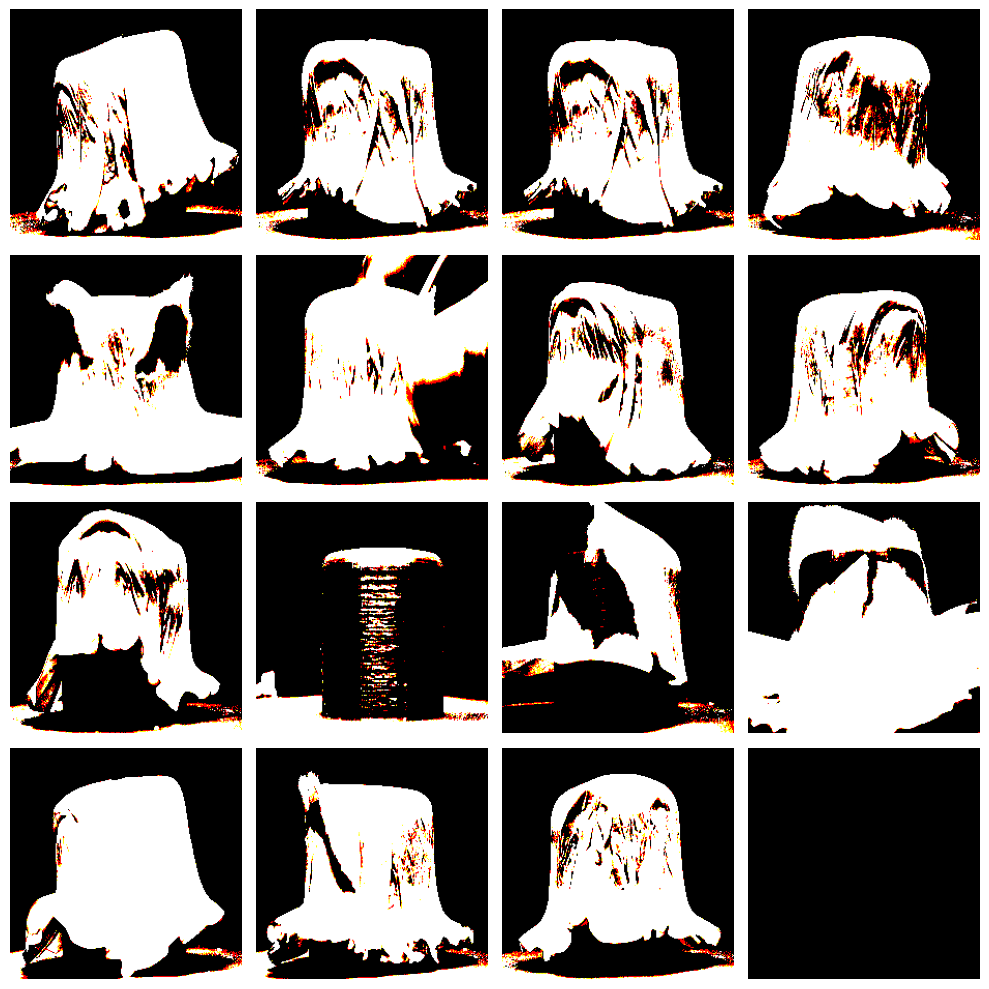

In [ ]:
def display_images_from_cluster(cluster_number, images_list, labels):
    """Display images from a specified cluster."""
    indices = [i for i, label in enumerate(labels) if label == cluster_number]
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(indices[:16]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images_list[index], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images from, say, cluster 0
display_images_from_cluster(0, images_list, labels)

In [ ]:
import pandas as pd  # For creating a CSV

# Merge clusters 0 and 2, and reassign labels
new_labels = []
for label in labels:
    if label in [0, 2]:
        new_labels.append(0)  # 1 represents 'bad'
    else:
        new_labels.append(1)  # 0 represents 'good'

# Save to CSV
df = pd.DataFrame({
    'image_file_name': image_file_names,
    'label': new_labels
})

csv_filename = "Res_side_image_labels.csv"
df.to_csv(csv_filename, index=False)
print(f"Labels saved to {csv_filename}")

Labels saved to Res_side_image_labels.csv
